# Import and misc

In [2]:
# Instal latest torch and torchaudio

In [3]:
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style('darkgrid')

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_

def set_random_seed(seed=42):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    # random.seed(seed)

# Task

In this notebook we will implement a model for finding a keyword in a stream.

We will implement the version with CRNN because it is easy and improves the model. 
(from https://www.dropbox.com/s/22ah2ba7dug6pzw/KWS_Attention.pdf)

In [4]:
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    num_workers: int = 2
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')
    
    max_window_length: int = 30

# Data

In [5]:
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
!mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log

--2022-11-06 23:12:09--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 2a00:1450:400f:801::2010, 74.125.131.128
Connecting to download.tensorflow.org (download.tensorflow.org)|2a00:1450:400f:801::2010|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1,4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

gz                   51%[=========>          ] 734,69M  24,2MB/s    eta 26s    ^C
mkdir: speech_commands: File exists


In [6]:
class SpeechCommandDataset(Dataset):

    def __init__(
        self,
        transform: Optional[Callable] = None,
        path2dir: str = None,
        keywords: Union[str, List[str]] = None,
        csv: Optional[pd.DataFrame] = None
    ):        
        self.transform = transform

        if csv is None:
            path2dir = pathlib.Path(path2dir)
            keywords = keywords if isinstance(keywords, list) else [keywords]
            
            all_keywords = [
                p.stem for p in path2dir.glob('*')
                if p.is_dir() and not p.stem.startswith('_')
            ]

            triplets = []
            for keyword in all_keywords:
                paths = (path2dir / keyword).rglob('*.wav')
                if keyword in keywords:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 1))
                else:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 0))
            
            self.csv = pd.DataFrame(
                triplets,
                columns=['path', 'keyword', 'label']
            )

        else:
            self.csv = csv
    
    def __getitem__(self, index: int):
        instance = self.csv.iloc[index]

        path2wav = instance['path']
        wav, sr = torchaudio.load(path2wav)
        wav = wav.sum(dim=0)
        
        if self.transform:
            wav = self.transform(wav)

        return {
            'wav': wav,
            'keywors': instance['keyword'],
            'label': instance['label']
        }

    def __len__(self):
        return len(self.csv)

In [7]:
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

In [8]:
dataset.csv.sample(5)

,path,keyword,label
17818,speech_commands/no/1b4c9b89_nohash_3.wav,no,0
15434,speech_commands/dog/3cfc6b3a_nohash_0.wav,dog,0
6420,speech_commands/cat/1678e6f1_nohash_0.wav,cat,0
54052,speech_commands/yes/6c968bd9_nohash_1.wav,yes,0
26021,speech_commands/stop/3e31dffe_nohash_3.wav,stop,0


### Augmentations

In [9]:
class AugsCreation:

    def __init__(self):
        self.background_noises = [
            'speech_commands/_background_noise_/white_noise.wav',
            'speech_commands/_background_noise_/dude_miaowing.wav',
            'speech_commands/_background_noise_/doing_the_dishes.wav',
            'speech_commands/_background_noise_/exercise_bike.wav',
            'speech_commands/_background_noise_/pink_noise.wav',
            'speech_commands/_background_noise_/running_tap.wav'
        ]

        self.noises = [
            torchaudio.load(p)[0].squeeze()
            for p in self.background_noises
        ]

    def add_rand_noise(self, audio):

        # randomly choose noise
        noise_num = torch.randint(low=0, high=len(
            self.background_noises), size=(1,)).item()
        noise = self.noises[noise_num]

        noise_level = torch.Tensor([1])  # [0, 40]

        noise_energy = torch.norm(noise)
        audio_energy = torch.norm(audio)
        alpha = (audio_energy / noise_energy) * \
            torch.pow(10, -noise_level / 20)

        start = torch.randint(
            low=0,
            high=max(int(noise.size(0) - audio.size(0) - 1), 1),
            size=(1,)
        ).item()
        noise_sample = noise[start: start + audio.size(0)]

        audio_new = audio + alpha * noise_sample
        audio_new.clamp_(-1, 1)
        return audio_new

    def __call__(self, wav):
        aug_num = torch.randint(low=0, high=4, size=(1,)).item()   # choose 1 random aug from augs
        augs = [
            lambda x: x,
            lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
            lambda x: torchaudio.transforms.Vol(.25)(x),
            lambda x: self.add_rand_noise(x)
        ]

        return augs[aug_num](wav)

In [10]:
set_random_seed()
indexes = torch.randperm(len(dataset))
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

In [11]:
# Sample is a dict of utt, word and label
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

### Sampler for oversampling:

In [12]:
# We should provide to WeightedRandomSampler _weight for every sample_; by default it is 1/len(target)

def get_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])   # for every class count it's number of occ.
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [13]:
train_sampler = get_sampler(train_set.csv['label'].values)

In [14]:
class Collator:
    
    def __call__(self, data):
        wavs = []
        labels = []    

        for el in data:
            wavs.append(el['wav'])
            labels.append(el['label'])

        # torch.nn.utils.rnn.pad_sequence takes list(Tensors) and returns padded (with 0.0) Tensor
        wavs = pad_sequence(wavs, batch_first=True)    
        labels = torch.Tensor(labels).long()
        return wavs, labels

###  Dataloaders

In [39]:
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.

train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=TaskConfig.num_workers, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=0, pin_memory=True)

### Creating MelSpecs on GPU for speeeed: 

In [16]:
class LogMelspec(nn.Module):

    def __init__(self, is_train, config):
        super().__init__()
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)

    # def __call__(self, batch):
    def forward(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

In [17]:
melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

### Quality measurment functions:

In [18]:
# FA - true: 0, model: 1
# FR - true: 1, model: 0

def count_FA_FR(preds, labels):
    FA = torch.sum(preds[labels == 0])
    FR = torch.sum(labels[preds == 0])
    
    # torch.numel - returns total number of elements in tensor
    return FA.item() / torch.numel(preds), FR.item() / torch.numel(preds)

In [19]:
def get_au_fa_fr(probs, labels):
    sorted_probs, _ = torch.sort(probs)
    sorted_probs = torch.cat((torch.Tensor([0]), sorted_probs, torch.Tensor([1])))
    labels = torch.cat(labels, dim=0)
        
    FAs, FRs = [], []
    print('sorted_probs', len(sorted_probs))
    for prob in tqdm(sorted_probs):
        preds = (probs >= prob) * 1
        FA, FR = count_FA_FR(preds, labels)        
        FAs.append(FA)
        FRs.append(FR)
    # plt.plot(FAs, FRs)
    # plt.show()

    # ~ area under curve using trapezoidal rule
    return -np.trapz(FRs, x=FAs)

# Model

In [56]:
class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        # print(input.shape)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output

config = TaskConfig()
model = CRNN(config)
model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [57]:
def train_epoch(model, opt, loader, log_melspec, device):
    model.train()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss = F.cross_entropy(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [22]:
@torch.no_grad()
def validation(model, loader, log_melspec, device):
    model.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

In [23]:
from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt

history = defaultdict(list)

# Training

In [24]:
set_random_seed()

config = TaskConfig(hidden_size=32)
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 32, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)


In [25]:
sum([p.numel() for p in model.parameters()])

25387

In [ ]:
# TRAIN

for n in range(TaskConfig.num_epochs):

    train_epoch(model, opt, train_loader,
                melspec_train, config.device)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

In [ ]:
history

### Reproduce

In [ ]:
history = defaultdict(list)
set_random_seed()
config = TaskConfig(hidden_size=32)
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

In [ ]:
# TRAIN

for n in range(TaskConfig.num_epochs):

    train_epoch(model, opt, train_loader,
                melspec_train, config.device)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

In [ ]:
history

# Streaming

Пишем обёртку, которую затем сконвертируем в jit и подадим в stream.py. Поддерживаем кэш и обновляем приходящими чанками. За основу берем модель model, которую подаём как параметр и которая должна состоять из свёртки conv, gru-слоя, attention и classifier.

In [27]:
class PewDiePie(nn.Module):
    def __init__(self, model, config, melspec):
        super().__init__()
        self.model = model
        # self.config = config
        self.time_ks = config.kernel_size[1]
        self.max_window_length = 402 * config.max_window_length * 2
        self.max_gru_length = config.max_window_length
        
        self.melspec = melspec
        self.melspec_window_size_half = 201

        self.spec_cache = None  # mel spec
        self.gru_cache = None
        self.gru_h = torch.zeros(config.gru_num_layers, 1, config.hidden_size)
        self.attn_cache = None
        self.probs = torch.zeros(1)
    
    @torch.no_grad()
    def stream(self, input):
        input = input.unsqueeze(dim=1)
        if self.spec_cache is None:
            self.spec_cache = input
        else:
            self.spec_cache = torch.cat((self.spec_cache, input), dim=-1)
        # time_ks = self.config.kernel_size[1]
        # print(f'{self.spec_cache.size()=}\t{time_ks=}')
        if self.spec_cache.size(-1) < self.time_ks:
            return None
        if self.spec_cache.size(1) > self.max_window_length:
            self.spec_cache = self.spec_cache[:,-self.max_window_length:,:]
        self.spec_cache = self.spec_cache[..., -self.time_ks:]
        x = self.model.conv(self.spec_cache).transpose(-1, -2)
        x, self.gru_h = self.model.gru(x, self.gru_h)
        if self.gru_cache is None:
            self.gru_cache = x
        else:
            self.gru_cache = torch.cat((self.gru_cache, x), dim=1)
        if self.gru_cache.size(1) > self.max_gru_length:
            self.gru_cache = self.gru_cache[:,1:,:]
        context_vector = self.model.attention(self.gru_cache)
        # print(f'{context_vector.size()=}')
        output = self.model.classifier(context_vector)
        # print(f'{output.size()=}')
        output = torch.softmax(output, dim=-1)
        # print(f'{output.size()=}')
        return output[..., -1].item()
    
    def forward(self, chunk):
        # print(chunk.size())
        if chunk.size(-1) < self.melspec_window_size_half:
            chunk = F.pad(chunk, (0, self.melspec_window_size_half - chunk.size(-1)))
        spec = self.melspec(chunk)
        # print(spec.size())
        return self.stream(spec)
        

In [41]:
config = TaskConfig(hidden_size=32)
model = CRNN(config).to(config.device)
model.load_state_dict(torch.load('base_3.56e-5.pth', map_location=config.device))

stream_model = PewDiePie(model, config, LogMelspec(is_train=False, config=config))

Склеим три трека так, чтобы центральным был трек с ключевым словом

In [29]:
index2 = np.where(val_df.label)[0][0]
index1 = np.where(~val_df.label)[0][0]
index3 = np.where(~val_df.label)[0][1]
ultra_wav = torch.cat((val_set[index1]['wav'], val_set[index2]['wav'], val_set[index3]['wav']))
print(f'{ultra_wav.size()=}')

ultra_wav.size()=torch.Size([36824])


In [30]:
results = []
for chunk in torch.split(ultra_wav, 201):
    chunk = chunk.view(1, -1)
    with torch.inference_mode():
        result = stream_model(chunk)
    # print(f"{result=}")
    if result is not None:
        results.append(result)

Ожидаем, что в центре вероятность будет высокой, а в первой и последней третях низкой

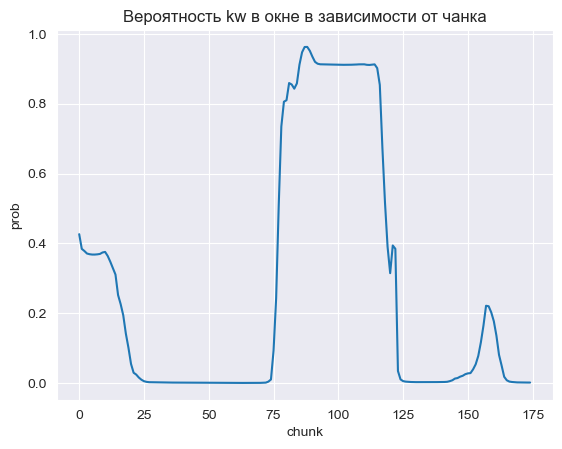

In [31]:
plt.plot(np.arange(len(results)), np.array(results))
plt.xlabel('chunk')
plt.ylabel('prob')
_ = plt.title('Вероятность kw в окне в зависимости от чанка')

Сохраняем для использования в stream.py

In [32]:
model_scripted = torch.jit.script(stream_model)
model_scripted.save('kws.pth') 

# Speed up & Compression

In [33]:
import time


class Timer:

    def __init__(self, name: str, verbose=False):
        self.name = name
        self.verbose = verbose

    def __enter__(self):
        self.t = time.time()
        return self

    def __exit__(self, type, value, traceback):
        self.t = time.time() - self.t

        if self.verbose:
            print(f"{self.name.capitalize()} | Elapsed time : {self.t:.2f}")

In [35]:
from thop import profile  # !pip install thop

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Conv1d(1, 1, 3, bias=False)
    
    def forward(self, x):
        return self.model(x)
        
profile(Model(), (torch.randn(1, 1, 4), ))  # -> (6.0 MACs, 3.0 parameters)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.


(6.0, 3.0)

In [36]:
import tempfile

def get_size_in_megabytes(model):
    # https://pytorch.org/tutorials/recipes/recipes/dynamic_quantization.html#look-at-model-size
    with tempfile.TemporaryFile() as f:
        torch.save(model.state_dict(), f)
        size = f.tell() / 2**20
    return size

#### Замерим base модель

In [85]:
config = TaskConfig(hidden_size=32)
model = CRNN(config).to(config.device)
model.load_state_dict(torch.load('base.pth', map_location=config.device))

<All keys matched successfully>

In [86]:
validation(model, val_loader, melspec_val, config.device)

102it [00:12,  7.85it/s]


sorted_probs 12947


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12947/12947 [00:03<00:00, 3716.29it/s]


4.556819332944547e-05

In [87]:
print(get_size_in_megabytes(model))

0.10112476348876953


In [88]:
two_seconds = melspec_val(torch.randn(1, 1, 2 * 16000))
prof = profile(model, two_seconds)
print(f'{prof[0]} MACs = {prof[0]/2} FLOPs')

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
904608.0 MACs = 452304.0 FLOPs


#### Квантизация

In [89]:
import torch.quantization
qmodel = torch.quantization.quantize_dynamic(model.cpu())

In [90]:
validation(qmodel, val_loader, melspec_val, 'cpu')

102it [00:12,  8.34it/s]


sorted_probs 12947


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12947/12947 [00:03<00:00, 3812.91it/s]


5.0169172514490324e-05

Метрики качества ОК!

После квантизации перф профайлить не получится, считаем таким же.  
Память:

In [91]:
print(get_size_in_megabytes(qmodel))

0.03718090057373047


In [92]:
print('compression rate', 0.10112476348876953 / 0.03718090057373047)

compression rate 2.7198040372431835


#### Дистилляция